In [4]:
import requests, zipfile, StringIO
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing,linear_model,cross_validation 
from sklearn.metrics import log_loss
import pickle
from copy import deepcopy
import seaborn as sns
# Plotting Options
sns.set_style("whitegrid")
sns.despine()

In [2]:
def read_csv_zip(filename):
    z = zipfile.ZipFile(filename+'.zip')
    df = pd.read_csv(z.open(filename))
    return df
train = read_csv_zip("train.csv")
test = read_csv_zip("test.csv")

In [3]:
train['X']=train['X'].apply(lambda x: -122.4313 if x>-122.3 else x)
test['X']=test['X'].apply(lambda x: -122.4313 if x>-122.3 else x)
train['Y']=train['Y'].apply(lambda x: 37.7799 if x>38 else x)
test['Y']=test['Y'].apply(lambda x: 37.7799 if x>38 else x)

In [4]:
#train["Address"].value_counts()[:20].plot(kind="bar")

In [5]:
# train["Category"].value_counts()

In [6]:
# top_10_crime

In [7]:
# train["PdDistrict"].value_counts()

In [8]:
def DateTimeFeature(df,dateColumn):
    df["DateIndex"] = pd.to_datetime(df[dateColumn])
    df["Year"] = df["DateIndex"].apply(lambda x: x.year)
    df["Month"] = df["DateIndex"].apply(lambda x: x.month)
    df["WeekDay"] = df["DateIndex"].apply(lambda x: x.weekday())
    df["Hour"] = df["DateIndex"].apply(lambda x: x.hour)   



In [9]:
DateTimeFeature(train,"Dates")

In [10]:
DateTimeFeature(test,"Dates")

top 10 crime 
'LARCENY/THEFT',
 'OTHER OFFENSES',
 'NON-CRIMINAL',
 'ASSAULT',
 'DRUG/NARCOTIC',
 'VEHICLE THEFT',
 'VANDALISM',
 'WARRANTS',
 'BURGLARY',
 'SUSPICIOUS OCC'

In [5]:
category_encoded = preprocessing.LabelEncoder()
category_encoded.fit(train["Category"])
train["category_encoded"] = category_encoded.transform(train["Category"])


In [13]:
address_encoded = preprocessing.LabelEncoder()
address_encoded.fit(list(train["Address"])+list(test["Address"]))
train["address_encoded"] = address_encoded.transform(train["Address"])
test["address_encoded"] = address_encoded.transform(test["Address"])

Learning with Counts,
referene: https://msdn.microsoft.com/en-us/library/azure/dn913056.aspx
https://www.kaggle.com/c/sf-crime/forums/t/15836/predicting-crime-categories-with-address-featurization-and-neural-nets
log odds of (# address A have Crime C/ # of address A) 

In [14]:
addresses=sorted(train["address_encoded"].unique())
categories=sorted(train["category_encoded"].unique())
C_counts=train.groupby(["category_encoded"]).size()
A_C_counts=train.groupby(["address_encoded","category_encoded"]).size()
A_counts=train.groupby(["address_encoded"]).size()

In [15]:

logodds={}
logoddsPA={}
MIN_CAT_COUNTS=2
row = float(len(train))
default_logodds=np.log(C_counts/row)-np.log(1.0-C_counts/row)
for addr in addresses:
    PA = A_counts[addr]/row
    logoddsPA[addr] = np.log(PA) - np.log(1.-PA)
    logodds[addr] = deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if A_C_counts[addr][cat]> MIN_CAT_COUNTS and A_C_counts[addr][cat]<A_counts[addr]:
            P_A_C = A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][cat] = np.log(P_A_C) - np.log(1.0 - P_A_C)
        logodds[addr] = pd.Series(logodds[addr],index = categories )
            
            
    

In [16]:
def address_feature(df,logodds,logoddsPA,categories):
    df["logoddsPA"] = df["address_encoded"].apply(lambda x: logoddsPA[x])
    logoddsPAC = df["address_encoded"].apply(lambda x: logodds[x])
    df["Intersection"] = df["Address"].apply(lambda x: 1 if "/" in x else 0)
    logoddsPAC.columns = ["logodds" + str(cat) for cat in categories]
    df = df.join(logoddsPAC.ix[:,:])
    address_feature =["Intersection","logoddsPA"]
    address_feature.extend(logoddsPAC.columns)
    # print df.head()
    return address_feature,df
train_address_feature,train = address_feature(train,logodds,logoddsPA,categories)    

In [17]:
categorical_feature = ["PdDistrict","Month","DayOfWeek"]
def categorical_feature_preprocess(categorical_feature,dataset):
    list_categorical = []
    for col in categorical_feature:
        dummy = pd.get_dummies(dataset[col])
        list_categorical.append(dummy)
    dataset_categorical = pd.concat(list_categorical,axis=1)
    return dataset_categorical

train_categorical = categorical_feature_preprocess(categorical_feature,train)

In [18]:
test_categorical = categorical_feature_preprocess(categorical_feature,test)

In [19]:
#Update the odds of address for the test data
new_addresses=sorted(test["address_encoded"].unique())
new_A_counts = test.groupby("address_encoded").size()
only_new=set(new_addresses+addresses)-set(addresses)
only_old=set(new_addresses+addresses)-set(new_addresses)
in_both=set(new_addresses).intersection(addresses)
for addr in only_new:
    PA = new_A_counts[addr]/float(len(test)+len(train))
    logoddsPA[addr] = np.log(PA) - np.log(1. - PA)
    logodds[addr] = deepcopy(default_logodds)
    logodds[addr].index=range(len(categories))
for addr in in_both:
    PA = (new_A_counts[addr] + A_counts[addr])/float(len(test)+len(train))
    logoddsPA[addr] = np.log(PA) - np.log(1. - PA)
test_address_feature,test = address_feature(test,logodds,logoddsPA,categories)


In [20]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y,DateIndex,Year,Month,...,logodds29,logodds30,logodds31,logodds32,logodds33,logodds34,logodds35,logodds36,logodds37,logodds38
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051,2015-05-10 23:59:00,2015,5,...,-8.688077,-5.259591,-7.454398,-2.772589,-11.893691,-4.777894,-2.533697,-2.335375,-2.533697,-4.621396
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432,2015-05-10 23:51:00,2015,5,...,-8.688077,-5.259591,-7.454398,-3.332205,-11.893691,-4.777894,-2.924890,-2.682075,-2.159484,-4.199705
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212,2015-05-10 23:50:00,2015,5,...,-8.688077,-5.259591,-7.454398,-3.294016,-11.893691,-4.777894,-2.924890,-1.223775,-2.985679,-4.621396
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015-05-10 23:45:00,2015,5,...,-8.688077,-5.259591,-7.454398,-2.888233,-11.893691,-5.095793,-2.373798,-4.240298,-2.929592,-3.608837
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412,2015-05-10 23:45:00,2015,5,...,-8.688077,-5.259591,-7.454398,-2.888233,-11.893691,-5.095793,-2.373798,-4.240298,-2.929592,-3.608837


In [21]:
continuous_feature = ["Year","Hour","X","Y"] + train_address_feature[1:]
def numerical_feature_preprocess(continuous_feature,train,test):
    scaler = StandardScaler()
    for col in continuous_feature:
        scaler.fit(train[col])
        train[col] = scaler.transform(train[col].reshape(-1, 1))
        test[col] = scaler.transform(test[col].reshape(-1, 1))
numerical_feature_preprocess(continuous_feature,train,test)  

/Users/ChiYuan/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ChiYuan/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ChiYuan/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ChiYuan/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by Standard

In [22]:
# test["PdDistrict_encoded"] = pd_district_encoded.transform(test["PdDistrict"])


In [23]:
train_data = pd.concat([train[continuous_feature + ["Intersection"]],train_categorical],axis=1)

train_data.head()


,Year,Hour,X,Y,logoddsPA,logodds0,logodds1,logodds2,logodds3,logodds4,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.73165,1.463813,-0.123710,0.312986,-0.645158,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
1,1.73165,1.463813,-0.123710,0.312986,-0.645158,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
2,1.73165,1.463813,-0.063250,1.381343,-1.008893,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
3,1.73165,1.463813,-0.167361,1.400310,0.025138,-0.065564,-1.096232,-0.087611,-0.157649,1.524265,...,0,0,0,0,0,0,0,0,0,1
4,1.73165,1.463813,-0.631782,0.186458,-0.566802,-0.065564,-0.076277,-0.087611,-0.157649,2.256390,...,0,0,0,0,0,0,0,0,0,1


In [24]:
test_data = pd.concat([test[continuous_feature+ ["Intersection"]],test_categorical],axis=1)
test_data.head()

,Year,Hour,X,Y,logoddsPA,logodds0,logodds1,logodds2,logodds3,logodds4,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.73165,1.463813,0.916643,-1.323649,-0.435417,-0.065564,0.515400,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,1,0,0,0
1,1.73165,1.463813,1.235615,-1.432019,0.162736,-0.065564,0.348945,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,1,0,0,0
2,1.73165,1.463813,-0.128072,1.041917,-1.060107,-0.065564,-0.076277,-0.087611,-0.157649,2.546570,...,0,0,0,0,0,0,1,0,0,0
3,1.73165,1.463813,-0.578640,-1.888083,0.626303,-0.065564,1.700197,-0.087611,-0.157649,-0.267456,...,0,0,0,0,0,0,1,0,0,0
4,1.73165,1.463813,-0.578640,-1.888083,0.626303,-0.065564,1.700197,-0.087611,-0.157649,-0.267456,...,0,0,0,0,0,0,1,0,0,0


In [25]:
test_data.shape

(884262, 74)

In [6]:
train_data = pd.read_csv("train_data_fe.csv") #train_data is saved separately
del train_data['Unnamed: 0']

In [7]:
train_data.head()

,Year,Hour,X,Y,logoddsPA,logodds0,logodds1,logodds2,logodds3,logodds4,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1.73165,1.463813,-0.123710,0.312986,-0.645158,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
1,1.73165,1.463813,-0.123710,0.312986,-0.645158,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
2,1.73165,1.463813,-0.063250,1.381343,-1.008893,-0.065564,-0.076277,-0.087611,-0.157649,-0.072074,...,0,0,0,0,0,0,0,0,0,1
3,1.73165,1.463813,-0.167361,1.400310,0.025138,-0.065564,-1.096232,-0.087611,-0.157649,1.524265,...,0,0,0,0,0,0,0,0,0,1
4,1.73165,1.463813,-0.631782,0.186458,-0.566802,-0.065564,-0.076277,-0.087611,-0.157649,2.256390,...,0,0,0,0,0,0,0,0,0,1


In [9]:
train_data.shape

(878049, 74)

In [12]:
from sklearn import decomposition

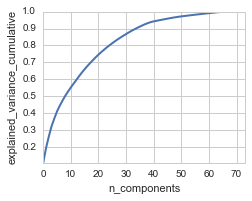

In [14]:
pca=decomposition.PCA()
pca.fit(train_data)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_.cumsum(), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_cumulative')

In [16]:
new_pca=decomposition.PCA(n_components=35)
new_pca.fit(train_data)
train_data_pca=new_pca.transform(train_data)
train_data_pca=pd.DataFrame(train_data_pca)

In [20]:
train_data_pca.shape

(878049, 35)

In [21]:
train_data.shape

(878049, 74)

In [10]:
from sklearn.ensemble import RandomForestClassifier
crime_rf = RandomForestClassifier(n_estimators=100,oob_score = True, min_samples_split=16, min_samples_leaf=8)

skipped the following cv as it will lead to issue of dead kernel
it produces cv scores  [-3.07570828 -2.55354627 -2.50239896 -2.52524975 -3.16510384]

In [ ]:
"""
rf_score = cross_validation.cross_val_score(crime_rf,train_data,train['category_encoded'],cv=5,scoring='log_loss')
print rf_score
"""




"\nrf_score = cross_validation.cross_val_score(crime_rf,train_data,train['category_encoded'],cv=5,scoring='log_loss')\nprint rf_score\n"

In [11]:

crime_rf.fit(train_data_pca,train['category_encoded'])
train_error = log_loss(train["category_encoded"],np.array(crime_rf.predict_proba(train_data_pca)))

In [ ]:
print train_error

In [ ]:
crime_rf.feature_importances_

In [ ]:
"""
train_data.to_csv("train_data_fe.csv",index = Fa)
test_data.to_csv("test_data_fe.csv")
"""

In [ ]:
np.mean((train["category_encoded"]==crime_rf.predict(train_data)))

In [ ]:
rf_predict = crime_rf.predict_proba(test_data)
rf_resulit = pd.DataFrame(rf_predict,columns = category_encoded.classes_)


In [ ]:
rf_resulit.head()
rf_resulit.to_csv("randomForest.csv",index=True,index_label ='Id' )